# Stock data with Alphavantage.co API 2018-07

This notebook contains a few experiments to work with the API of Alphavantage.co which seems the currently best stock data source. There is the Python package `fix-yahoo-finance` which does what the name says, but at least for the immediate future us personal and low-volume stock data grabbers seem to be well served by Alphavantage for now.

The road ahead is unclear as it seems that they are just exploring potential business models https://digit.hbs.org/submission/alpha-vantage-platform-strategy-in-the-financial-data-api-market/ but many of their current user base might well accept a monetization strategy.

This notebook resulted from codeexperiments for the Google Apps Engine, where the standard tier offers Python2.7 containers. Quick results are always achieved in Python leveraging the Pandas package, but for the Apps Engine cloud version a pure lists/dictionaries/sequences variatin was also needed.

In [1]:
import json
import os
from pprint import pformat

import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import requests

import datetime
import matplotlib.dates as mdates

#python3 -m pip install mpl_finance
from mpl_finance import candlestick_ohlc

#python3 -m pip install ipywidgets
from ipywidgets import widgets

In [2]:
apikey="demo"
try:
    with open(os.path.join("./stocksconfig.json")) as f:
        config = json.load(f)
        apikey = config['alphavantage']['apikey']
        config['alphavantage']['apikey'] = '****************'
        print("This is how the config file looks like:\n{}\n\n".format(pformat(config)))
except FileNotFoundError: #IOError
    print("Get or retrieve your API Key from https://www.alphavantage.co/support/#api-key")

if apikey == "demo":
    print("Insert the API key from https://www.alphavantage.co/support/#api-key and press Enter")
    input_variable = widgets.Text(value='', placeholder='0123456789abcdef', description='Insert API Keyand press Enter:', disabled=False )
    def bind_global_apikey(sender):
        global apikey
        if len(str(input_variable.value)) == 16:
            apikey = input_variable.value
            #print("Going to use apikey ", apikey)
        else:
            print("Must be 16 characters long: ", apikey)
    input_variable.on_submit(bind_global_apikey)
    display(input_variable)


This is how the config file looks like:
{'alphavantage': {'apikey': '****************'}}




## Grab data

This notebook is using the requests library docs.python-requests.org to query the API for json data.
Then a few transformations are done to come up with a more generic dataframe.

In [3]:
#if still no valid apikey
if apikey == "demo":
    symbol = "MSFT"
else:
    symbol = '^GDAXI'

# the endpoint is for TIME_SERIES_DAILY_ADJUSTED
# https://www.alphavantage.co/documentation/#dailyadj
r = requests.get(url='https://www.alphavantage.co/query?function=TIME_SERIES_DAILY_ADJUSTED&symbol={0}&apikey={1}'.format(symbol, apikey))
#I like to keep such calls in a separate cell so I can work on the object locally

## With Pandas

In [4]:
df = pd.DataFrame.from_dict(r.json()['Time Series (Daily)'], orient="index")

# the data needs to be casted into non-strings
df=df.astype(float) #https://stackoverflow.com/a/31495326

# and the index need to be proper dates
df.index = pd.to_datetime(df.index)
# and for easier consumption later the index is added as a column
df['Date'] = df.index.map(mdates.date2num)

# finally some more generic column names
df = df.rename(columns={'1. open': 'Open', '2. high': 'High', '3. low': 'Low', '5. adjusted close': 'Close'})

#a brief glimpse into the data
df.head()


,Open,High,Low,4. close,Close,6. volume,7. dividend amount,8. split coefficient,Date
2018-03-16,12345.5596,12454.0195,12337.6201,12389.5801,12389.5801,212840100.0,0.0,1.0,736769.0
2018-03-19,12346.5098,12369.7695,12183.7900,12217.0195,12217.0195,97309700.0,0.0,1.0,736772.0
2018-03-20,12261.1904,12320.0000,12191.5498,12307.3301,12307.3301,72907500.0,0.0,1.0,736773.0
2018-03-21,12336.7598,12344.0898,12250.3701,12309.1504,12309.1504,108917200.0,0.0,1.0,736774.0
2018-03-22,12187.7305,12267.1699,12009.5000,12100.0801,12100.0801,138428600.0,0.0,1.0,736775.0


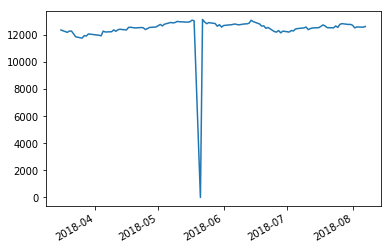

In [5]:
#But there is a problam with ^GDAXI at Whit Monday (Pfingstmontag)
#The visual inspection shows it immediately
df['Close'].plot();

In [6]:
# an inspection of the dataframe reveals a zero 'price'
df.describe()

,Open,High,Low,4. close,Close,6. volume,7. dividend amount,8. split coefficient,Date
count,100.000000,100.000000,100.000000,100.000000,100.000000,1.000000e+02,100.0,100.0,100.000000
mean,12467.393742,12530.278270,12389.743322,12463.323194,12463.323194,9.615255e+07,0.0,1.0,736842.600000
std,1293.480628,1298.450322,1287.862485,1293.755777,1293.755777,3.582955e+07,0.0,0.0,41.589383
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.0,1.0,736769.000000
25%,12369.815175,12450.492175,12305.342025,12390.952675,12390.952675,8.159458e+07,0.0,1.0,736807.750000
50%,12599.995150,12645.839850,12532.669950,12588.200200,12588.200200,9.793810e+07,0.0,1.0,736843.500000
75%,12814.122275,12860.929900,12742.787625,12809.685325,12809.685325,1.086124e+08,0.0,1.0,736878.250000
max,13138.830100,13204.309600,13061.769500,13169.919900,13169.919900,2.576705e+08,0.0,1.0,736913.000000


In [7]:
# when was that?
df.idxmin(axis=0)

Open                   2018-05-21
High                   2018-05-21
Low                    2018-05-21
4. close               2018-05-21
Close                  2018-05-21
6. volume              2018-04-27
7. dividend amount     2018-03-16
8. split coefficient   2018-03-16
Date                   2018-03-16
dtype: datetime64[ns]

In [8]:
# here is the row for that particular index
df[df.index.to_pydatetime() == datetime.datetime(2018,5,21)]

,Open,High,Low,4. close,Close,6. volume,7. dividend amount,8. split coefficient,Date
2018-05-21,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,736835.0


In [9]:
# for the supplied list of columns, remove every row with at least one column being zero
# this drops some data, which might suit most usecases

#https://codereview.stackexchange.com/a/185390
df = df[(df[['Open', 'High', 'Low', 'Close']] != 0).all(axis=1)]
df.describe()

,Open,High,Low,4. close,Close,6. volume,7. dividend amount,8. split coefficient,Date
count,99.000000,99.000000,99.000000,99.000000,99.000000,9.900000e+01,99.0,99.0,99.000000
mean,12593.327012,12656.846737,12514.892244,12589.215347,12589.215347,9.712379e+07,0.0,1.0,736842.676768
std,296.753780,291.329445,305.461938,299.713082,299.713082,3.466357e+07,0.0,0.0,41.793913
min,11868.080100,11961.160200,11726.620100,11787.259800,11787.259800,0.000000e+00,0.0,1.0,736769.000000
25%,12380.985350,12469.399900,12323.609850,12394.365250,12394.365250,8.195355e+07,0.0,1.0,736807.500000
50%,12602.410200,12647.160200,12534.629900,12590.830100,12590.830100,9.856650e+07,0.0,1.0,736844.000000
75%,12814.854950,12861.270000,12745.745150,12810.140150,12810.140150,1.086480e+08,0.0,1.0,736878.500000
max,13138.830100,13204.309600,13061.769500,13169.919900,13169.919900,2.576705e+08,0.0,1.0,736913.000000


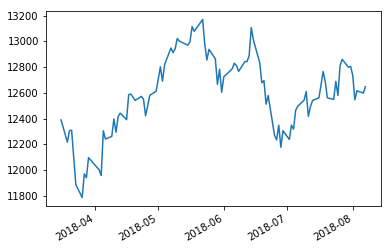

In [10]:
# seeing is believing:
df['Close'].plot();

In [11]:
#df['Date'] = df.index #for single index
#for multiindex see https://stackoverflow.com/a/46920777

#df3['Date'] = df3.index.map(mdates.date2num)

#Making a subset of the dataframe for consumption by candlestick_ohlc()
ohlc = df[['Date','Open','High','Low','Close']]

ohlc.head()


,Date,Open,High,Low,Close
2018-03-16,736769.0,12345.5596,12454.0195,12337.6201,12389.5801
2018-03-19,736772.0,12346.5098,12369.7695,12183.7900,12217.0195
2018-03-20,736773.0,12261.1904,12320.0000,12191.5498,12307.3301
2018-03-21,736774.0,12336.7598,12344.0898,12250.3701,12309.1504
2018-03-22,736775.0,12187.7305,12267.1699,12009.5000,12100.0801


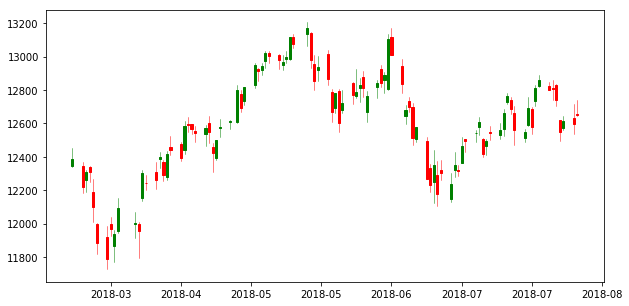

In [12]:
# finally a candlestick chart

f1, ax = plt.subplots(figsize = (10,5))

# plot the candlesticks
candlestick_ohlc(ax, ohlc.values, width=.6, colorup='green', colordown='red')
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))


plt.show();

## With plain Python

In [13]:
#import numpy as np
import datetime
from matplotlib import dates

In [14]:
data = r.json()

In [15]:
date = []
open = []
high = []
low = []
close = []
ohlc = []
for day in data['Time Series (Daily)']:
    if data['Time Series (Daily)'][day]['1. open'] != '0.0000':
        date.append(dates.date2num(datetime.datetime.strptime(day, '%Y-%m-%d')))
        open.append(data['Time Series (Daily)'][day]['1. open'])
        high.append(data['Time Series (Daily)'][day]['2. high'])
        low.append(data['Time Series (Daily)'][day]['3. low'])
        close.append(data['Time Series (Daily)'][day]['5. adjusted close'])
        appendme = dates.date2num(datetime.datetime.strptime(day, '%Y-%m-%d')), \
        float(data['Time Series (Daily)'][day]['1. open']),\
        float(data['Time Series (Daily)'][day]['2. high']),\
        float(data['Time Series (Daily)'][day]['3. low']),\
        float(data['Time Series (Daily)'][day]['5. adjusted close'])
        ohlc.append(appendme)
                   

## Plain Python with matplotlib styling

In [16]:
import mplsol
mplsol.setup()

In [17]:
#https://github.com/NichtJens/matplotlib-solarized-colorcycle/blob/master/mplsol.py

import matplotlib as mpl

#dark
# BB BB CC CC C C B B
# 03 02 01 __ 0 1 _ _

#light
# BB BB CC CC C C B B
# __ __ 01 00 _ 1 2 3

# -> edges/labels (black): 0/00
# -> inner face   (white): 03/3
# -> outer face   (grey):  02/2


base03  = "#002b36"
base02  = "#073642"
base01  = "#586e75"
base00  = "#657b83"
base0   = "#839496"
base1   = "#93a1a1"
base2   = "#eee8d5"
base3   = "#fdf6e3"
yellow  = "#b58900"
orange  = "#cb4b16"
red     = "#dc322f"
magenta = "#d33682"
violet  = "#6c71c4"
blue    = "#268bd2"
cyan    = "#2aa198"
green   = "#859900"


color_cycles = {
    "def":  "bgrcmvk",
    "def+": "bgrcmvkoy",
    "mpl":  "bgrcmyk",
    "mpl+": "bgrcmykov",
    "sol":  "kyormvbcg",
}



def make_cycler(color_dict, color_string):
    lst = [color_dict[c] for c in color_string]
    cyc = mpl.cycler(color=lst)
    return cyc


def setup(color="def", lines_only=True, dark=False):

    if color in color_cycles:
        color = color_cycles[color]

    if dark:
        black = base0
        grey  = base02
        white = base03
    else:
        black = base00
        grey  = base2
        white = base3

    color_dict = {
        "y": yellow,
        "o": orange,
        "r": red,
        "m": magenta,
        "v": violet,
        "b": blue,
        "c": cyan,
        "g": green,
        "k": black,
        "e": grey,
        "w": white
    }

    color_cycler = make_cycler(color_dict, color)

    params = {
        "axes.prop_cycle": color_cycler
    }

    if not lines_only:
        params.update({
            "axes.edgecolor":    black, # k
            "axes.facecolor":    white, # w
            "axes.labelcolor":   black, # k
            "figure.edgecolor":  white, # w
            "figure.facecolor":  grey,  # 0.75
            "grid.color":        black, # k
            "patch.edgecolor":   black, # k
            "patch.facecolor":   blue,  # b
            "savefig.facecolor": grey,  # w
            "text.color":        black, # k
            "xtick.color":       black, # k
            "ytick.color":       black, # k
        })

    mpl.rcParams.update(params)



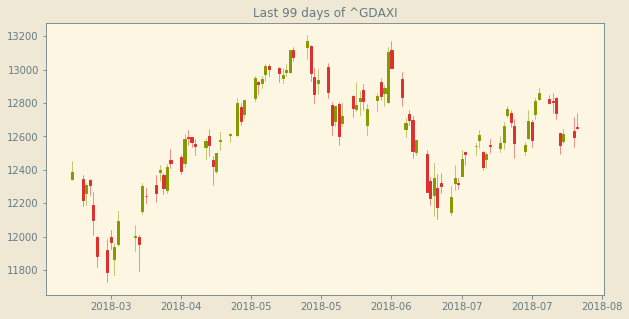

In [18]:
#https://matplotlib.org/api/finance_api.html
setup(color="sol", lines_only=False, dark=False)

f1, ax = plt.subplots(figsize = (10,5))

candlestick_ohlc(ax, ohlc,
                 width=0.6, colorup='#859900', colordown='#dc322f');
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.title("Last {0} days of {1}".format(len(ohlc), symbol));
plt.show();

That's it for now!